<a href="https://colab.research.google.com/github/vgaquino/capstone-team-29/blob/main/cross_evaluation_captions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import csv
import pandas as pd
import json
import zipfile
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize

In [ ]:
# Get the current working directory
current_dir = os.getcwd()
space_dir = "drive/MyDrive/Colab Notebooks/"

amazon_file = 'rekognition_val_outputs.csv'
kosmos_file = 'kosmos_val_outputs.csv'
blip2_file = 'blip2_val_outputs.csv'

# Construct the relative paths
file1_path = os.path.join(current_dir, space_dir, amazon_file)
file2_path = os.path.join(current_dir, space_dir, kosmos_file)
file3_path = os.path.join(current_dir, space_dir, blip2_file)

# Open and read the CSV files
with open(file1_path, 'r') as file1, open(file2_path, 'r') as file2, open(file3_path, 'r') as file3:
    amazon_df = pd.read_csv(file1)
    kosmos_df = pd.read_csv(file2)
    blip2_df = pd.read_csv(file3)


In [ ]:
new_column_names = {'tokens': 'amazon_tokens'}
amazon_df.rename(columns=new_column_names, inplace=True)
amazon_df.head()

,image_id,amazon_tokens
0,0,"['Computer', 'Electronics', 'Laptop', 'Pc', 'S..."
1,1,"['Food', 'Seasoning', 'Syrup']"
2,2,"['Publication', 'Book', 'Text', 'Animal', 'Can..."
3,3,['Toothpaste']
4,4,"['Electronics', 'Screen', 'Computer Hardware',..."


In [ ]:
new_column_names = {'caption': 'kosmos_captions', 'entity_list':'kosmos_entity_list'}
kosmos_df.rename(columns=new_column_names, inplace=True)

def unique_elements(x):
    return list(set(x))

# Group by image_id and aggregate other columns
kosmos_groupby_df = kosmos_df.groupby('image_id').agg({
    'kosmos_captions': 'first',  # Take the first caption (assuming they are all the same)
    'kosmos_entity_list': unique_elements  # Aggregate unique elements in entity list
}).reset_index()

kosmos_groupby_df.head()

,image_id,kosmos_captions,kosmos_entity_list
0,0,"a computer screen with a message that says ""Yo...","[a message that says ""You must repair the comp..."
1,1,a bottle of Night Tree in a hand,"[Night Tree, a hand]"
2,2,a book cover with a dog and a cow walking down...,"[a book cover, a dog, a cow]"
3,3,two boxes of condoms,[two boxes of condoms]
4,4,a computer screen with a ZoomText error message,"[a computer screen, a ZoomText error message]"


In [ ]:
new_column_names = {'caption': 'blip2_captions'}
blip2_df.rename(columns=new_column_names, inplace=True)
blip2_df.head()

,image_id,blip2_captions
0,0,a laptop computer with a message on the screen
1,1,a person holding a bottle of night time
2,2,a book titled dog years by mark lindgren
3,3,a toothbrush and a tube of toothpaste on a table
4,4,a computer screen with a message on it


In [ ]:
#Extract captions from VizWiz annotations (val.json, train.json, test.json)
zip_files = ['/content/drive/MyDrive/Colab Notebooks/annotations.zip']

#Destination folder for extracted files
destination_folder = '/content/'

#Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

#Loop through each zip file
for zip_file in zip_files:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        #Extract the contents of the zip file to the destination folder
        zip_ref.extractall(destination_folder)
with open('annotations/val.json', 'r') as f:
    annotation_data = json.load(f)

caption_list = []
id_list = []
for captions in annotation_data['annotations']:
    caption_list.append(captions['caption'])
    id_list.append(captions['image_id'])

df_reference = pd.DataFrame(data={'reference': caption_list, 'image_id': id_list})
df_reference['image_id'] = df_reference['image_id'] - 23431 # adjust image id and image name

In [ ]:
df_reference.head()

,reference,image_id
0,A computer screen shows a repair prompt on the...,0
1,a computer screen with a repair automatically ...,0
2,partial computer screen showing the need of re...,0
3,Part of a computer monitor showing a computer ...,0
4,The top of a laptop with a blue background and...,0


In [ ]:
#Focus on captions similarity between BLIP-2 and Kosmos-2 against VizWiz
merged_df = pd.merge(df_reference, blip2_df, on='image_id', how='inner')
merged_df = pd.merge(merged_df, kosmos_groupby_df.drop('kosmos_entity_list', axis = 1), on='image_id', how='inner')
merged_df = merged_df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
merged_df.set_index('image_id').head(15)

,reference,blip2_captions,kosmos_captions
image_id,,,
0,a computer screen shows a repair prompt on the...,a laptop computer with a message on the screen,"a computer screen with a message that says ""yo..."
0,a computer screen with a repair automatically ...,a laptop computer with a message on the screen,"a computer screen with a message that says ""yo..."
0,partial computer screen showing the need of re...,a laptop computer with a message on the screen,"a computer screen with a message that says ""yo..."
0,part of a computer monitor showing a computer ...,a laptop computer with a message on the screen,"a computer screen with a message that says ""yo..."
0,the top of a laptop with a blue background and...,a laptop computer with a message on the screen,"a computer screen with a message that says ""yo..."
1,a person is holding a bottle that has medicine...,a person holding a bottle of night time,a bottle of night tree in a hand
1,a bottle of medication has a white twist top.,a person holding a bottle of night time,a bottle of night tree in a hand
1,night time medication bottle being held by som...,a person holding a bottle of night time,a bottle of night tree in a hand
1,a person holding a small black bottle of night...,a person holding a bottle of night time,a bottle of night tree in a hand


Remove the images whose caption is "quality problems were too severe to infer the content". This will help us get some clues on where the models differ.

In [ ]:
# Calculate the number of rows in the original DataFrame
original_rows = len(merged_df)

# Filter out rows containing the specified string
df_filtered = merged_df[~merged_df['reference'].str.contains("quality issues are too severe to recognize visual content")]

# Calculate the number of rows in the filtered DataFrame
filtered_rows = len(df_filtered)

# Calculate the reduction in dataset size
reduction = original_rows - filtered_rows
reduction_perc = (original_rows - filtered_rows) / original_rows * 100

# Print the reduction
print(f"The dataset size was reduced to {reduction} rows after filtering. The dataset size was reduced by {reduction_perc:.2f}%.")


The dataset size was reduced to 5199 rows after filtering. The dataset size was reduced by 13.42%.


Calculate the Bleu Score. We assume the Smoothingfunction method in order to address issues where certain n-grams (sequences of words) in a generated text may not overlap with those in a reference text, leading to zero counts and consequently a BLEU score of zero, despite potential partial semantic similarity. Reference: https://www.nltk.org/api/nltk.translate.bleu_score.html

In [ ]:
df = df_filtered

# Function to calculate BLEU score with smoothing
def calculate_bleu(reference, caption):
    smoothing_function = SmoothingFunction().method1
    return sentence_bleu([reference], caption, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing_function)

# Calculate BLEU scores and select best score for blip2_captions
df['blip2_scores'] = df.apply(lambda row: calculate_bleu(row['reference'], row['blip2_captions']), axis=1)
df['blip2_best_score'] = df.groupby('image_id')['blip2_scores'].transform('max')

# Calculate BLEU scores and select best score for kosmos_captions
df['kosmos_scores'] = df.apply(lambda row: calculate_bleu(row['reference'], row['kosmos_captions']), axis=1)
df['kosmos_best_score'] = df.groupby('image_id')['kosmos_scores'].transform('max')


<ipython-input-123-81bcd360929e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['blip2_scores'] = df.apply(lambda row: calculate_bleu(row['reference'], row['blip2_captions']), axis=1)
<ipython-input-123-81bcd360929e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['blip2_best_score'] = df.groupby('image_id')['blip2_scores'].transform('max')
<ipython-input-123-81bcd360929e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [ ]:
# Calculate the mean score for each method
blip2_mean_score = df['blip2_best_score'].mean()
kosmos_mean_score = df['kosmos_best_score'].mean()

# Determine which method performed better
if blip2_mean_score > kosmos_mean_score:
    better_method = 'BLIP-2'
    difference = blip2_mean_score - kosmos_mean_score
elif kosmos_mean_score > blip2_mean_score:
    better_method = 'Kosmos'
    difference = kosmos_mean_score - blip2_mean_score
else:
    better_method = 'Both methods have equal performance'
    difference = 0

print(f"The method '{better_method}' performed better over the majority of the image IDs by an average difference of {difference:.4f}.")


The method 'BLIP-2' performed better over the majority of the image IDs by an average difference of 0.0435.


Visualization of the difference in the scores for the first 25 images (quality issues filtered out).

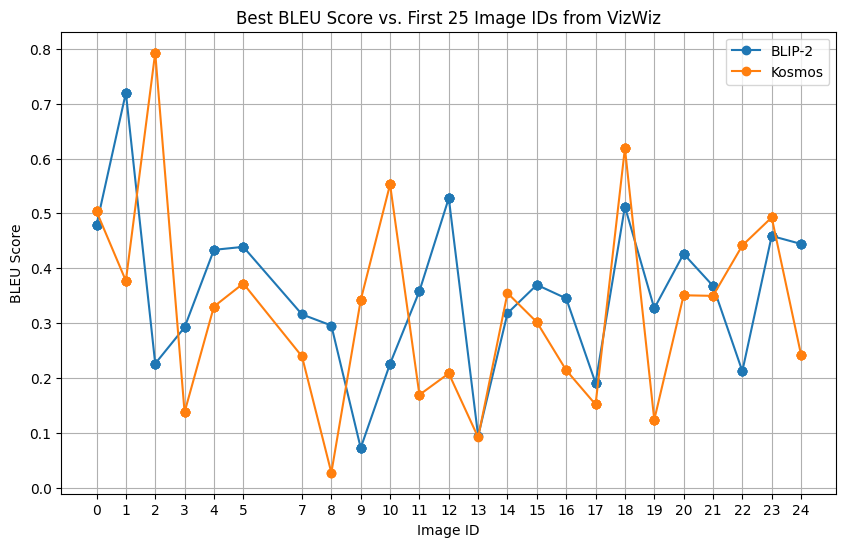

In [ ]:
df = df_filtered.head(101)

# Plot the scores vs. image_id
plt.figure(figsize=(10, 6))
plt.plot(df['image_id'], df['blip2_best_score'], label='BLIP-2', marker='o')
plt.plot(df['image_id'], df['kosmos_best_score'], label='Kosmos', marker='o')
plt.xlabel('Image ID')
plt.ylabel('BLEU Score')
plt.title('Best BLEU Score vs. First 25 Image IDs from VizWiz')
plt.legend()
plt.grid(True)

# Set the x-axis ticks to be discrete (image_id values)
plt.xticks(df['image_id'].unique())
#plt.annotate('caption\nremoved', xy=(6, 0), xytext=(6, 0.03), ha='center',
#             #arrowprops=dict(facecolor='gray', shrink=0.01, linewidth=0.01),
#             fontsize=6,
#             color='gray')


plt.show()

In [ ]:
df.head(25)

**Best Scores for Captions**

In [176]:
# Sort the DataFrame by 'kosmos_best_score' and 'blip2_best_score' in ascending order
kosmos_best_df = df[df['kosmos_best_score'] == df['kosmos_scores']]
best_kosmos_scores = kosmos_best_df.sort_values(by='kosmos_best_score', ascending=False).head(5)

blip2_best_df = df[df['blip2_best_score'] == df['blip2_scores']]
best_blip2_scores = blip2_best_df.sort_values(by='blip2_best_score', ascending=False).head(5)

# Display the worst performing examples for Kosmos
print("Best performing examples for Kosmos:")
print(best_kosmos_scores[['image_id','reference', 'kosmos_captions', 'kosmos_best_score']])

# Display the worst performing examples for BLIP-2
print("\nBest performing examples for BLIP-2:")
print(best_blip2_scores[['image_id','reference', 'blip2_captions', 'blip2_best_score']])

Best performing examples for Kosmos:
     image_id                                          reference  \
12          2  a book with a black and a tan dog walking down...   
94         18       part of the keyboard and screen on a laptop.   
50         10  a view of a building with a picture of a man o...   
1           0  a computer screen with a repair automatically ...   
115        23  computer monitor currently on a wooden compute...   

                                       kosmos_captions  kosmos_best_score  
12   a book cover with a dog and a cow walking down...           0.792843  
94          a laptop with a broken screen and keyboard           0.618652  
50   a building with a large poster of a man on it,...           0.552725  
1    a computer screen with a message that says "yo...           0.503738  
115          a computer monitor and keyboard on a desk           0.492616  

Best performing examples for BLIP-2:
     image_id                                          refer

In [ ]:
kosmos_scores = df['kosmos_best_score']
blip2_scores = df['blip2_best_score']

# Calculate Pearson correlation coefficient
correlation = round(kosmos_scores.corr(blip2_scores), 4)

print("Correlation between Kosmos and BLIP-2 best scores:", correlation)

Correlation between Kosmos and BLIP-2 best scores: 0.0763


**Worst Scores for Captions** - Error analysis

In [177]:
# Select worst score for blip2_captions
df['blip2_worst_score'] = df.groupby('image_id')['blip2_scores'].transform('max')

# Select worst score for kosmos_captions
df['kosmos_worst_score'] = df.groupby('image_id')['kosmos_scores'].transform('max')

# Sort the DataFrame by 'kosmos_worst_score' and 'blip2_worst_score' in ascending order
kosmos_worst_df = df[df['kosmos_worst_score'] == df['kosmos_scores']]
worst_kosmos_scores = kosmos_worst_df.sort_values(by='kosmos_worst_score').head(5)

blip2_worst_df = df[df['blip2_worst_score'] == df['blip2_scores']]
worst_blip2_scores = blip2_worst_df.sort_values(by='blip2_worst_score').head(5)

pd.set_option('display.max_columns', None)
# Display the worst performing examples for Kosmos
print("Worst performing examples for Kosmos:")
print(worst_kosmos_scores[['image_id','reference', 'kosmos_captions', 'kosmos_worst_score']])

# Display the worst performing examples for BLIP-2
print("\nWorst performing examples for BLIP-2:")
print(worst_blip2_scores[['image_id','reference', 'blip2_captions', 'blip2_worst_score']])

Worst performing examples for Kosmos:
    image_id                                          reference  \
43         8  a small bottle of lotion on a table above a pe...   
65        13  a white piece of paper with a blue emblem off ...   
97        19  the back of a dell laptop which shows the labe...   
19         3  two boxes of pharmaceutical products left in a...   
88        17   human stand beside table and cd titles windows 7   

                        kosmos_captions  kosmos_worst_score  
43            a woman peeing into a cup            0.027247  
65  a light bulb and a pair of scissors            0.091718  
97        a laptop with a sticker on it            0.123791  
19                 two boxes of condoms            0.137589  
88        a cd and a shadow of a person            0.151614  

Worst performing examples for BLIP-2:
     image_id                                          reference  \
48          9             a vehicle has a window and a gray bar.   
65         1

In [ ]:
# Calculate the difference between 'kosmos_best_score' and 'blip2_best_score'
df['score_difference'] = df['kosmos_best_score'] - df['blip2_best_score']

# Sort the DataFrame by the score difference in descending order
sorted_df = df.sort_values(by='score_difference', ascending=False)

# Select the top 5 image_id with the largest difference
top_5_image_id = sorted_df.head(5)

print("Top 5 image_id with the largest difference between Kosmos and BLIP-2:")
print(top_5_image_id)

Top 5 image_id with the largest difference between Kosmos and BLIP-2:
                                            reference  image_id  \
12  a book with a black and a tan dog walking down...         2   
14  a book cover title dog years with an image of ...         2   
13          the book cover shows two dogs in the snow         2   
10  a white paper showing an image of black and br...         2   
11  a library book with pictures of two dogs on th...         2   

                              blip2_captions  \
12  a book titled dog years by mark lindgren   
14  a book titled dog years by mark lindgren   
13  a book titled dog years by mark lindgren   
10  a book titled dog years by mark lindgren   
11  a book titled dog years by mark lindgren   

                                      kosmos_captions  blip2_scores  \
12  a book cover with a dog and a cow walking down...      0.200390   
14  a book cover with a dog and a cow walking down...      0.041528   
13  a book cover with a d

<ipython-input-128-074ae479db6d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score_difference'] = df['kosmos_best_score'] - df['blip2_best_score']
